# Prepare Data and Enivronment

Using RandomForest, Cross_validation, GridSearch, Confusion_matrix

In [ ]:
#import the dataset from drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.9 MB/s eta 0:00:00


In [ ]:
import json
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from category_encoders import OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [ ]:
def wrangle(filename):
  # Import and open the csv file
  df = pd.read_csv(filename)

  # Identify leaky columns
  df.drop(columns = "cellphone_access", inplace = True)

  # Drop high cardinality
  #df.drop(columns = "uniqueid", inplace = True)


  return df

In [ ]:
train_df = wrangle("/content/drive/MyDrive/Financial Inclusion in Africa/Train.csv")
print(train_df.shape)
train_df.head()

(23524, 12)


,country,year,uniqueid,bank_account,location_type,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


## Explore

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   household_size          23524 non-null  int64 
 6   age_of_respondent       23524 non-null  int64 
 7   gender_of_respondent    23524 non-null  object
 8   relationship_with_head  23524 non-null  object
 9   marital_status          23524 non-null  object
 10  education_level         23524 non-null  object
 11  job_type                23524 non-null  object
dtypes: int64(3), object(9)
memory usage: 2.2+ MB


In [ ]:
train_df["country"].value_counts()

Rwanda      8735
Tanzania    6620
Kenya       6068
Uganda      2101
Name: country, dtype: int64

In [ ]:
# Plot class Balance
train_df["bank_account"].value_counts(normalize = True).plot(
    kind = "bar",
    xlabel = "Bank account",
    ylabel = "Frequency",
    title = "Class Balance"
);

## Split

In [ ]:
# The vertical split
target = "bank_account"
X = train_df.drop(columns = target)
y = train_df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (23524, 11)
y shape: (23524,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18819, 11)
y_train shape: (18819,)
X_test shape: (4705, 11)
y_test shape: (4705,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

## Resample

In [ ]:
over_sampler = RandomOverSampler(random_state = 42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (25918, 11)


,country,year,uniqueid,location_type,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Rwanda,2016,uniqueid_4854,Urban,4,39,Male,Head of Household,Married/Living together,Primary education,Other Income
1,Rwanda,2016,uniqueid_5689,Urban,5,17,Female,Child,Single/Never Married,Secondary education,Remittance Dependent
2,Tanzania,2017,uniqueid_193,Urban,1,57,Female,Head of Household,Married/Living together,Primary education,Self employed
3,Uganda,2018,uniqueid_1212,Urban,12,17,Female,Parent,Single/Never Married,Primary education,Self employed
4,Tanzania,2017,uniqueid_5593,Urban,2,30,Male,Head of Household,Single/Never Married,Secondary education,Informally employed


# Build Model

## Baseline

In [ ]:
acc_baseline = y_train.value_counts(normalize = True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.8608


## Iterate

In [ ]:
clf = make_pipeline(
    SimpleImputer(strategy = "most_frequent"), OrdinalEncoder(), MinMaxScaler(feature_range=(0, 1)), RandomForestClassifier(random_state = 42)
)
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder', OrdinalEncoder()),
                ('minmaxscaler', MinMaxScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


In [ ]:
cv_acc_scores = cross_val_score(clf, X_train_over, y_train_over, cv = 5, n_jobs = -1)
print(cv_acc_scores)

[0.93402778 0.96469907 0.96547068 0.96372757 0.96064056]


In [ ]:
params = {
    "simpleimputer__strategy": ["most_frequent"],
    "randomforestclassifier__n_estimators": range(25, 100, 25),
    "randomforestclassifier__max_depth": range(10, 50, 10)
}
params

{'simpleimputer__strategy': ['most_frequent'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

In [ ]:
model = GridSearchCV(
    clf,
    param_grid = params,
    cv = 5,
    n_jobs = -1,
    verbose = 1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('ordinalencoder', OrdinalEncoder()),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['most_frequent']},
             verbose=1)

In [ ]:
# Train model
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('ordinalencoder', OrdinalEncoder()),
                                       ('minmaxscaler', MinMaxScaler()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['most_frequent']},
             verbose=1)

In [ ]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.662191,0.096471,0.198206,0.006820,10,25,most_frequent,"{'randomforestclassifier__max_depth': 10, 'ran...",0.824074,0.838542,0.836998,0.826741,0.811885,0.827648,0.009676,11
1,1.950706,0.387813,0.156109,0.039829,10,50,most_frequent,"{'randomforestclassifier__max_depth': 10, 'ran...",0.825424,0.836998,0.829668,0.827320,0.813429,0.826568,0.007654,12
2,2.135030,0.046008,0.147130,0.004679,10,75,most_frequent,"{'randomforestclassifier__max_depth': 10, 'ran...",0.825039,0.836227,0.834877,0.830214,0.816323,0.828536,0.007260,10
3,1.917854,0.768159,0.197304,0.085943,20,25,most_frequent,"{'randomforestclassifier__max_depth': 20, 'ran...",0.927083,0.956983,0.961420,0.954852,0.949836,0.950035,0.012066,9
4,2.977948,1.115617,0.151971,0.008866,20,50,most_frequent,"{'randomforestclassifier__max_depth': 20, 'ran...",0.929398,0.962770,0.962577,0.958904,0.953695,0.953469,0.012478,6
5,4.381181,2.067366,0.259900,0.084203,20,75,most_frequent,"{'randomforestclassifier__max_depth': 20, 'ran...",0.930941,0.961613,0.962384,0.957939,0.953695,0.953314,0.011604,7
6,1.418418,0.256604,0.146303,0.073797,30,25,most_frequent,"{'randomforestclassifier__max_depth': 30, 'ran...",0.929012,0.958140,0.960069,0.957361,0.957746,0.952466,0.011764,8
7,4.374623,1.327776,0.286907,0.100262,30,50,most_frequent,"{'randomforestclassifier__max_depth': 30, 'ran...",0.933256,0.964892,0.963542,0.963342,0.961219,0.957250,0.012054,2
8,3.339734,0.932659,0.183953,0.004137,30,75,most_frequent,"{'randomforestclassifier__max_depth': 30, 'ran...",0.931327,0.962770,0.962770,0.960833,0.958518,0.955244,0.012060,4
9,1.180277,0.038015,0.123049,0.016109,40,25,most_frequent,"{'randomforestclassifier__max_depth': 40, 'ran...",0.930363,0.961034,0.960841,0.960255,0.958518,0.954202,0.011953,5


In [ ]:
mask = cv_results["param_randomforestclassifier__max_depth"] == 10
cv_results[mask]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.662191,0.096471,0.198206,0.006820,10,25,most_frequent,"{'randomforestclassifier__max_depth': 10, 'ran...",0.824074,0.838542,0.836998,0.826741,0.811885,0.827648,0.009676,11
1,1.950706,0.387813,0.156109,0.039829,10,50,most_frequent,"{'randomforestclassifier__max_depth': 10, 'ran...",0.825424,0.836998,0.829668,0.827320,0.813429,0.826568,0.007654,12
2,2.135030,0.046008,0.147130,0.004679,10,75,most_frequent,"{'randomforestclassifier__max_depth': 10, 'ran...",0.825039,0.836227,0.834877,0.830214,0.816323,0.828536,0.007260,10


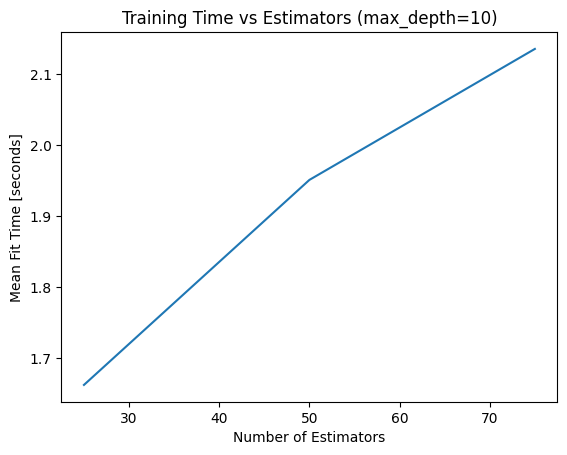

In [ ]:
# Create mask
mask = cv_results["param_randomforestclassifier__max_depth"] == 10
# Plot fit time vs n_estimators
plt.plot(
    cv_results[mask]["param_randomforestclassifier__n_estimators"],
    cv_results[mask]["mean_fit_time"]
)
# Label axes
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth=10)");

In [ ]:
mask = cv_results["param_randomforestclassifier__n_estimators"] == 25
cv_results[mask]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.662191,0.096471,0.198206,0.006820,10,25,most_frequent,"{'randomforestclassifier__max_depth': 10, 'ran...",0.824074,0.838542,0.836998,0.826741,0.811885,0.827648,0.009676,11
3,1.917854,0.768159,0.197304,0.085943,20,25,most_frequent,"{'randomforestclassifier__max_depth': 20, 'ran...",0.927083,0.956983,0.961420,0.954852,0.949836,0.950035,0.012066,9
6,1.418418,0.256604,0.146303,0.073797,30,25,most_frequent,"{'randomforestclassifier__max_depth': 30, 'ran...",0.929012,0.958140,0.960069,0.957361,0.957746,0.952466,0.011764,8
9,1.180277,0.038015,0.123049,0.016109,40,25,most_frequent,"{'randomforestclassifier__max_depth': 40, 'ran...",0.930363,0.961034,0.960841,0.960255,0.958518,0.954202,0.011953,5


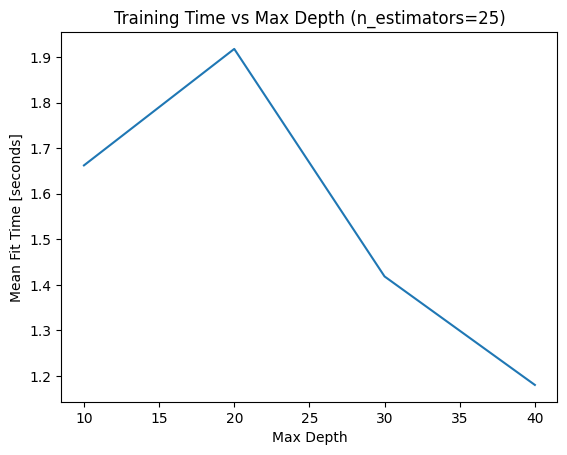

In [ ]:
# Create mask
mask = cv_results["param_randomforestclassifier__n_estimators"] == 25
# Plot fit time vs max_depth
plt.plot(
    cv_results[mask]["param_randomforestclassifier__max_depth"],
    cv_results[mask]["mean_fit_time"]
)
# Label axes
plt.xlabel("Max Depth")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Max Depth (n_estimators=25)");

In [ ]:
# Extract best hyperparameters
model.best_params_

{'randomforestclassifier__max_depth': 40,
 'randomforestclassifier__n_estimators': 50,
 'simpleimputer__strategy': 'most_frequent'}

## Evaluate

In [ ]:
acc_train = model.score(X_train_over, y_train_over)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9999
Test Accuracy: 0.8648


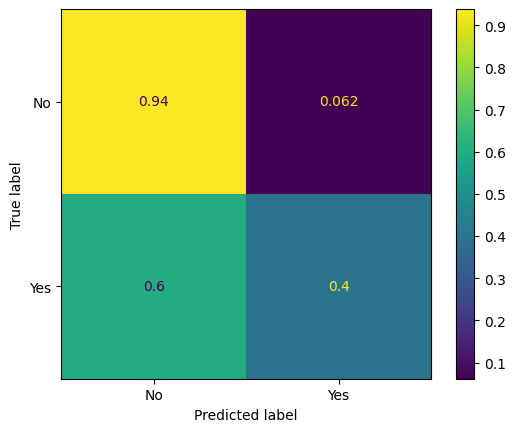

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize='true');

# Communicate Result

In [ ]:
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
importances

array([0.04851577, 0.02629071, 0.23397729, 0.03761511, 0.0917076 ,
       0.18053819, 0.02280391, 0.03832942, 0.03849128, 0.15496625,
       0.12676447])

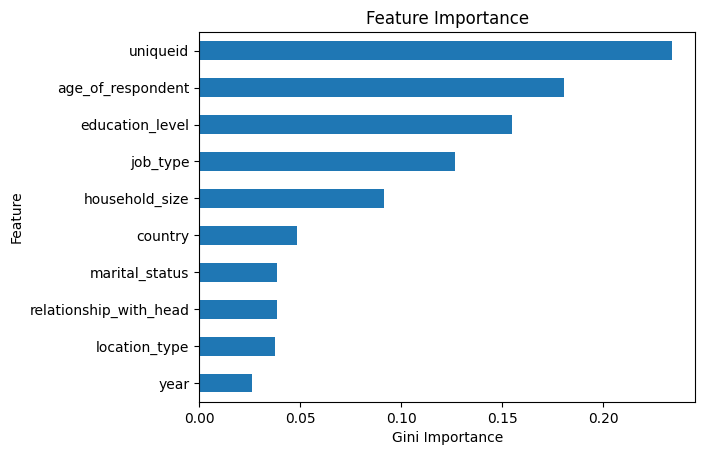

In [ ]:
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index = features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot( kind = "barh"

)
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

## Model on test data

In [ ]:
# First save the two models. the model_reg, the model_over and model_over_d

# Save model
with open("/content/drive/MyDrive/Financial Inclusion in Africa/model_RF.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
def make_predictions(data_filepath, submission_filepath, model_filepath, filename):
    # Wrangle JSON file
    X_test = wrangle(data_filepath)

    # Import and open the csv file
    submission = pd.read_csv(submission_filepath)

    # Load model
    with open(model_filepath, "rb") as f:
        model = pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred, index = X_test.index, name = "bankrupt")

    # Create submission DataFrame
    submission = pd.DataFrame({"uniqueid": X_test["uniqueid"] + " x " + X_test["country"],
                           "bank_account": y_test_pred})

    # Create submission csv file csv file
    submission.to_csv(filename, index = False)
    return submission

In [ ]:
view_result = make_predictions(
    data_filepath="/content/drive/MyDrive/Financial Inclusion in Africa/Test.csv",
    submission_filepath = "/content/drive/MyDrive/Financial Inclusion in Africa/SampleSubmission.csv",
    model_filepath = "/content/drive/MyDrive/Financial Inclusion in Africa/model_RF.pkl",
    filename = "/content/drive/MyDrive/Financial Inclusion in Africa/Fourth_Submission.csv"
)

In [ ]:
view_result.head()

,uniqueid,bank_account
0,uniqueid_6056 x Kenya,Yes
1,uniqueid_6060 x Kenya,Yes
2,uniqueid_6065 x Kenya,No
3,uniqueid_6072 x Kenya,No
4,uniqueid_6073 x Kenya,No
